In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Basics').getOrCreate()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pylab import rcParams
from pyspark.sql.functions import avg
import pyspark.sql.functions as f
from pyspark.sql.window import Window #***
from pyspark.sql.functions import sum
from pyspark.sql.functions import format_number


df = spark.read.csv('healthcare-dataset-stroke-data.csv', inferSchema=True,header=True)

In [81]:
df.show()


+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [3]:
df.describe().show()

+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|             5110|  5110|              5110|              5110|               5110|        5110|     5110|          5110|              5110|              5110|          5110|               5110|
|   mean|36517.82935420744|  null|43.226614481409015|0.0974559686888454|0.05401174168297456|        null|     null|          null|106.14767710371804|28.893236911794673|          null| 

In [4]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [5]:
df.groupBy('gender').mean().show()

+------+-----------------+-----------------+-------------------+-------------------+----------------------+--------------------+
|gender|          avg(id)|         avg(age)|  avg(hypertension)| avg(heart_disease)|avg(avg_glucose_level)|         avg(stroke)|
+------+-----------------+-----------------+-------------------+-------------------+----------------------+--------------------+
|Female|36479.68503674015|43.75739478957918|0.09218436873747494|0.03774215096860387|    104.05780895123563|0.047094188376753505|
| Other|          56156.0|             26.0|                0.0|                0.0|                143.33|                 0.0|
|  Male|36562.54137115839|42.48338534278962| 0.1049645390070922|0.07706855791962175|     109.0885200945626| 0.05106382978723404|
+------+-----------------+-----------------+-------------------+-------------------+----------------------+--------------------+



In [6]:
display(df.groupBy("gender").avg("stroke").orderBy("gender"))

DataFrame[gender: string, avg(stroke): double]

In [7]:
   df.groupBy('gender','stroke').mean().show()

+------+------+------------------+-----------------+-------------------+-------------------+----------------------+-----------+
|gender|stroke|           avg(id)|         avg(age)|  avg(hypertension)| avg(heart_disease)|avg(avg_glucose_level)|avg(stroke)|
+------+------+------------------+-----------------+-------------------+-------------------+----------------------+-----------+
|  Male|     1| 37566.67592592593|             68.5|               0.25|0.25925925925925924|    143.15935185185185|        1.0|
| Other|     0|           56156.0|             26.0|                0.0|                0.0|                143.33|        0.0|
|Female|     0| 36465.37889940414|42.60193480546795|0.08307045215562565|0.03294777427269541|    103.05175254118453|        0.0|
|  Male|     0|  36508.5072247135|41.08338814150475|0.09715994020926756|0.06726457399103139|    107.25511210762329|        0.0|
|Female|     1|36769.156028368794|67.13702127659575| 0.2765957446808511| 0.1347517730496454|    124.4143

In [37]:
df1 = df.groupBy('stroke').count()
df1.show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



/home/giotanna/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

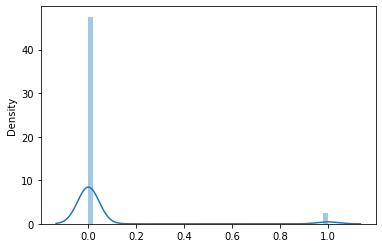

In [33]:
sample_df = df.select(['stroke']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()
sns.distplot(pandas_df)

In [123]:
#influence of work type on getting stroke
#more private
df_work_type_stroke = df.groupBy('work_type', 'stroke').count().select('stroke','work_type',f.col('count').alias('work_type_count')).withColumn('percentage_of_work_type',(f.col('work_type_count') / df.count()) * 100 ).filter(df['stroke'] == 1).select('work_type','work_type_count',(format_number('percentage_of_work_type',2).alias('percentage_of_work_type'))).orderBy('work_type_count')


df_work_type_stroke.show()

+-------------+---------------+-----------------------+
|    work_type|work_type_count|percentage_of_work_type|
+-------------+---------------+-----------------------+
|     children|              2|                   0.04|
|     Govt_job|             33|                   0.65|
|Self-employed|             65|                   1.27|
|      Private|            149|                   2.92|
+-------------+---------------+-----------------------+



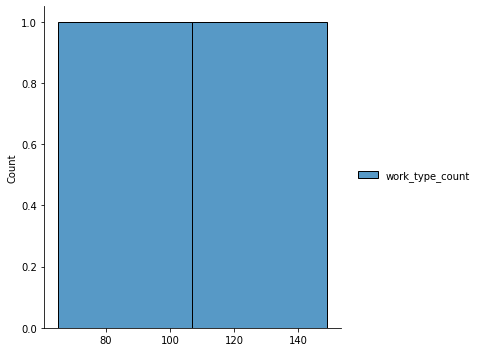

In [67]:
sa_df = df_stroke.select(['work_type_count']).sample(False,0.1,5)
pandas_df = sa_df.toPandas()
sns.displot(pandas_df)

In [122]:
#participated in this clinic measurement
#58% Female. 41% Male
df_mes = df.groupBy('gender').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_gender',(f.col('count_gender') / df.count()) * 100 ).select('gender','count_gender',(format_number('percentage_of_gender',2).alias('percentage_of_gender'))).orderBy('count_gender')

df_mes.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_gender|
+------+------------+--------------------+
| Other|           1|                0.02|
|  Male|        2115|               41.39|
|Female|        2994|               58.59|
+------+------------+--------------------+



In [3]:
df.sum().show()

AttributeError: 'DataFrame' object has no attribute 'sum'

In [13]:
# how many female/male have a stroke
# 2,11% Male. 2,76% Female
df_gen_str_M = df.groupBy('gender', 'stroke').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Male')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_gen_str_M.show()

df_gen_str_F = df.groupBy('gender', 'stroke').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Female')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_gen_str_F.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|  Male|         108|                2.11|
+------+------------+--------------------+

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|         141|                2.76|
+------+------------+--------------------+



In [120]:
#people have heart disease and stroke
df_stroke_heartdisease = df.groupBy('gender', 'stroke', 'heart_disease').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['heart_disease'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_gender')

df_stroke_heartdisease.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|          19|                0.37|
|  Male|          28|                0.55|
+------+------------+--------------------+



In [121]:
#people have hypertension and stroke
df_stroke_hypertension = df.groupBy('gender', 'stroke', 'hypertension').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['hypertension'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_gender')

df_stroke_hypertension.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|  Male|          27|                0.53|
|Female|          39|                0.76|
+------+------------+--------------------+



In [87]:
#people have heart disease and hypertension and stroke
df_stroke_heartd_hyperd = df.groupBy('gender', 'stroke', 'heart_disease','hypertension').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_stroke',(f.col('count_gender') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['heart_disease'] == '1') & (df['hypertension'] == '1')).select('gender','count_gender',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_stroke_heartd_hyperd.show()

+------+------------+--------------------+
|gender|count_gender|percentage_of_stroke|
+------+------------+--------------------+
|Female|           7|                0.14|
|  Male|           6|                0.12|
+------+------------+--------------------+



In [6]:
#people have heart disease and hypertension 
df_heartd_hyperd = df.groupBy('gender','heart_disease','hypertension').count().select('gender',f.col('count').alias('count_gender')).withColumn('percentage_of_both',(f.col('count_gender') / df.count()) * 100 ).filter((df['heart_disease'] == '1') & (df['hypertension'] == '1')).select('gender','count_gender',(format_number('percentage_of_both',2).alias('percentage_of_both')))

df_heartd_hyperd.show()

+------+------------+------------------+
|gender|count_gender|percentage_of_both|
+------+------------+------------------+
|  Male|          35|              0.68|
|Female|          29|              0.57|
+------+------------+------------------+



In [133]:
#influence of smoking_status on getting stroke
df_stroke_smoking= df.groupBy('smoking_status', 'stroke').count().select('smoking_status',f.col('count').alias('count_smoking_status')).withColumn('percentage_of_stroke',(f.col('count_smoking_status') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('smoking_status','count_smoking_status',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_smoking_status')

df_stroke_smoking.show()

+---------------+--------------------+--------------------+
| smoking_status|count_smoking_status|percentage_of_stroke|
+---------------+--------------------+--------------------+
|         smokes|                  42|                0.82|
|        Unknown|                  47|                0.92|
|formerly smoked|                  70|                1.37|
|   never smoked|                  90|                1.76|
+---------------+--------------------+--------------------+



In [7]:
#influence of smoking_status  and gender
df_stroke_smoking_Female= df.groupBy('smoking_status', 'stroke', 'gender').count().select('gender','smoking_status',f.col('count').alias('count_smoking_status')).withColumn('percentage_of_stroke',(f.col('count_smoking_status') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Female')).select('smoking_status','count_smoking_status',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke_Female'))).orderBy('count_smoking_status')

df_stroke_smoking_Female.show()

+---------------+--------------------+---------------------------+
| smoking_status|count_smoking_status|percentage_of_stroke_Female|
+---------------+--------------------+---------------------------+
|         smokes|                  19|                       0.37|
|        Unknown|                  25|                       0.49|
|formerly smoked|                  34|                       0.67|
|   never smoked|                  63|                       1.23|
+---------------+--------------------+---------------------------+



In [127]:
#influence of smoking_status on getting stroke
df_stroke_smoking_Male= df.groupBy('smoking_status', 'stroke', 'gender').count().select('gender','smoking_status',f.col('count').alias('count_smoking_status')).withColumn('percentage_of_stroke',(f.col('count_smoking_status') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['gender'] == 'Male')).select('smoking_status','count_smoking_status',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke_Male'))).orderBy('count_smoking_status')
df_stroke_smoking_Male.show()

+---------------+--------------------+-------------------------+
| smoking_status|count_smoking_status|percentage_of_stroke_Male|
+---------------+--------------------+-------------------------+
|        Unknown|                  22|                     0.43|
|         smokes|                  23|                     0.45|
|   never smoked|                  27|                     0.53|
|formerly smoked|                  36|                     0.70|
+---------------+--------------------+-------------------------+



In [125]:
#influence of Residence_type on getting stroke **************** auti i analisi den xreiazetai??? bgazoyme apla to siberasma oti den epireazetai apo ton tipo tou aimatos
df_stroke_restype= df.groupBy('Residence_type', 'stroke').count().select('Residence_type',f.col('count').alias('count_Residence_type')).withColumn('percentage_of_stroke',(f.col('count_Residence_type') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('Residence_type','count_Residence_type',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_Residence_type')

df_stroke_restype.show()

+--------------+--------------------+--------------------+
|Residence_type|count_Residence_type|percentage_of_stroke|
+--------------+--------------------+--------------------+
|         Rural|                 114|                2.23|
|         Urban|                 135|                2.64|
+--------------+--------------------+--------------------+



In [20]:
#influence of ever_married on getting stroke
df_stroke_ever_married= df.groupBy('ever_married', 'stroke').count().select('ever_married',f.col('count').alias('count_ever_married')).withColumn('percentage_of_stroke',(f.col('count_ever_married') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('ever_married','count_ever_married',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_ever_married')

df_stroke_ever_married.show()

+------------+------------------+--------------------+
|ever_married|count_ever_married|percentage_of_stroke|
+------------+------------------+--------------------+
|          No|                29|                0.57|
|         Yes|               220|                4.31|
+------------+------------------+--------------------+



In [23]:
#influence of ever_married on getting stroke by gender (general Female are at risk to have a stoke)
df_stroke_ever_married= df.groupBy('gender','ever_married', 'stroke').count().select('gender','ever_married',f.col('count').alias('count_ever_married')).withColumn('percentage_of_stroke',(f.col('count_ever_married') / df.count()) * 100 ).filter((df['stroke'] == 1)).select('gender','ever_married','count_ever_married',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke'))).orderBy('count_ever_married')

df_stroke_ever_married.show()


+------+------------+------------------+--------------------+
|gender|ever_married|count_ever_married|percentage_of_stroke|
+------+------------+------------------+--------------------+
|  Male|          No|                 8|                0.16|
|Female|          No|                21|                0.41|
|  Male|         Yes|               100|                1.96|
|Female|         Yes|               120|                2.35|
+------+------------+------------------+--------------------+



In [102]:
#people have hypertension and stroke and over 50 ******************* mporoume na omadipoioisoyme kapoies ilikies ?? diladi 50-60,60-70,70-80,80-90?????
df_stroke_hypertension_over50 = df.groupBy('gender', 'stroke', 'hypertension','age').count().select('age',f.col('count').alias('count_age')).withColumn('percentage_of_stroke',(f.col('count_age') / df.count()) * 100 ).filter((df['stroke'] == 1) & (df['hypertension'] == '1') &(df['age'] > 50)).select('age','count_age',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_stroke_hypertension_over50.show()

+----+---------+--------------------+
| age|count_age|percentage_of_stroke|
+----+---------+--------------------+
|76.0|        2|                0.04|
|79.0|        1|                0.02|
|68.0|        3|                0.06|
|75.0|        1|                0.02|
|80.0|        5|                0.10|
|57.0|        2|                0.04|
|57.0|        1|                0.02|
|53.0|        1|                0.02|
|60.0|        1|                0.02|
|82.0|        3|                0.06|
|73.0|        1|                0.02|
|70.0|        1|                0.02|
|74.0|        1|                0.02|
|72.0|        2|                0.04|
|51.0|        1|                0.02|
|76.0|        1|                0.02|
|81.0|        2|                0.04|
|74.0|        1|                0.02|
|69.0|        1|                0.02|
|78.0|        5|                0.10|
+----+---------+--------------------+
only showing top 20 rows



In [34]:
df.filter((df['stroke'] == 1) & (df['age'] > '50') & (df['hypertension'] == 1)).count()

63

In [35]:
df.filter((df['stroke'] == 1) & (df['age'] > '50')).count()

226

In [36]:
df.filter((df['stroke'] == 1) & (df['age'] > '50') & (df['heart_disease'] == 1)).count()

47

In [37]:
df.filter((df['stroke'] == 1) & (df['age'] < '50')).count()

20

In [16]:
#sort by stroke and age > 50         *** den xreiazete
df_age = df.groupBy('age','stroke').count().select('stroke','age',f.col('count').alias('age_count')).withColumn('percentage_of_stroke',(f.col('age_count') / df.count()) * 100 ).filter(df['stroke'] == 1).select('age','age_count',(format_number('percentage_of_stroke',2).alias('percentage_of_stroke')))

df_age = df_age.orderBy(df_age['age_count'].desc())

df_age.show()

+----+---------+--------------------+
| age|age_count|percentage_of_stroke|
+----+---------+--------------------+
|78.0|       21|                0.41|
|79.0|       17|                0.33|
|80.0|       17|                0.33|
|81.0|       14|                0.27|
|57.0|       11|                0.22|
|76.0|       10|                0.20|
|63.0|        9|                0.18|
|74.0|        9|                0.18|
|82.0|        9|                0.18|
|68.0|        9|                0.18|
|77.0|        8|                0.16|
|59.0|        8|                0.16|
|58.0|        7|                0.14|
|71.0|        7|                0.14|
|61.0|        6|                0.12|
|75.0|        6|                0.12|
|54.0|        6|                0.12|
|69.0|        6|                0.12|
|70.0|        6|                0.12|
|72.0|        6|                0.12|
+----+---------+--------------------+
only showing top 20 rows



In [24]:
# calculate the number of stroke cases for people *********den xriazete
df.filter((df['stroke'] == 1)).count()

249

In [19]:
# calculate the number of stroke cases for people after 50 years ***** den xriazete
df.filter((df['stroke'] == 1) & (df['age'] > '50')).count()

226

In [20]:
#percentage person over 50 that have stroke
#4.4 %
df_age_per = ((df.filter((df['stroke'] == 1) & (df['age'] > '50')).count() ) / df.count() ) * 100 
df_age_per


4.422700587084149

In [39]:
#percentage person under 50 that have stroke
#0.39 %
df_age_per1 = ((df.filter((df['stroke'] == 1) & (df['age'] < '50')).count() ) / df.count() ) * 100 
df_age_per1

0.3913894324853229